# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import sys
import dotenv

dotenv.load_dotenv()

from bb_energy_prediction.data_utils import read_bb_data 

c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
data_path = os.getenv("ENERGY_DATASET_PATH")

# Parsing files

In [2]:
result_files = [f for f in os.listdir(data_path) if f.endswith("results")]
data_df = pd.DataFrame()

for file in result_files:
    file_df = read_bb_data(f"{data_path}/{file}/breaker_code.txt", f"{data_path}/{file}/breaker_final_energy.txt")
    file_df = file_df.drop(columns=["bb_name"])
    file_df["program_name"] = file.rsplit("_results", 1)[0]
    data_df = pd.concat([data_df, file_df], ignore_index=True)

Read file: 5500it [00:00, 1575513.73it/s]
Read file: 1007it [00:00, 669784.99it/s]
Read file: 23757it [00:00, 1583814.10it/s]
Read file: 3281it [00:00, 935520.83it/s]
Read file: 65377it [00:00, 1633842.25it/s]
Read file: 10955it [00:00, 811010.31it/s]
Read file: 6018it [00:00, 1201967.69it/s]
Read file: 988it [00:00, 658609.72it/s]
Read file: 58765it [00:00, 1526559.36it/s]
Read file: 10347it [00:00, 940582.22it/s]
Read file: 7827it [00:00, 1304179.94it/s]
Read file: 1281it [00:00, 427098.84it/s]
Read file: 307469it [00:00, 1145131.49it/s]
Read file: 55158it [00:00, 889583.07it/s]
Read file: 300342it [00:00, 1393711.50it/s]
Read file: 49541it [00:00, 892630.14it/s]
Read file: 117151it [00:00, 813567.17it/s]
Read file: 19125it [00:00, 932831.71it/s]
Read file: 32428it [00:00, 1621981.61it/s]
Read file: 3856it [00:00, 962635.33it/s]
Read file: 252048it [00:00, 1647358.46it/s]
Read file: 41397it [00:00, 950681.96it/s]
Read file: 226630it [00:00, 1624600.05it/s]
Read file: 39698it [00:00, 

In [3]:
print(f"Number of basic blocks: {len(data_df)}")

Number of basic blocks: 565679


In [4]:
data_df.head(5)

,bb,energy,program_name
0,"[movl $0x0, -0x2c(%rbp)]",0.842119,binary_search
1,"[callq 0xfffffffffffffeff, pushq %rbp, mov %...",0.358601,binary_search
2,"[popq %rbp, retq]",0.165508,binary_search
3,"[movl $0x0, -0x1c(%rbp)]",0.842119,binary_search
4,"[cmpl $0x64, -0x1c(%rbp), jnl 0x2c]",1.263179,binary_search


# Analysis

Distribution based on number of instructions

In [8]:
bb_instruction_num = data_df.bb.apply(lambda x: len(x)).values

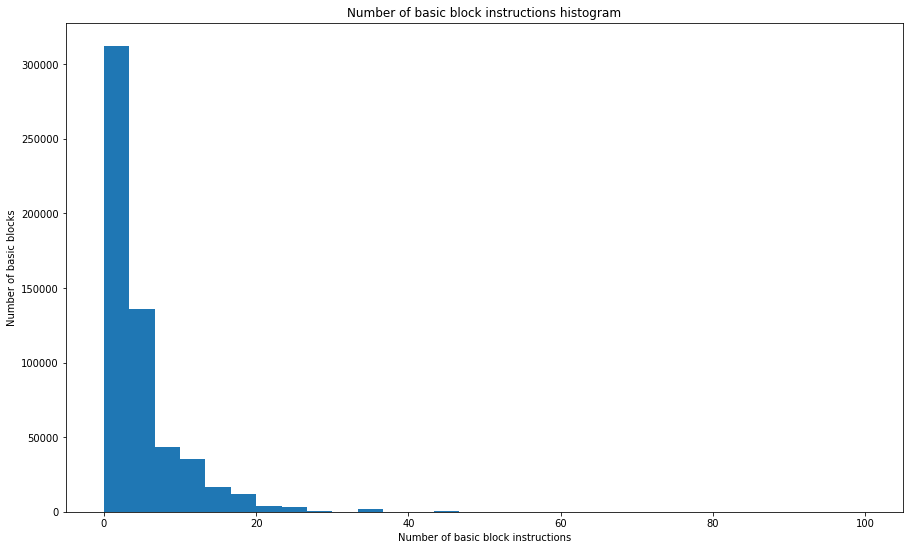

In [9]:
plt.figure(figsize=(15,9))
plt.title("Number of basic block instructions histogram")
plt.xlabel("Number of basic block instructions")
plt.ylabel("Number of basic blocks")
plt.hist(bb_instruction_num, bins=30, range=(0,100))
plt.show()

In [10]:
np.mean(bb_instruction_num)

5.04076870451263

In [11]:
MAX_INSTRUCTIONS = 20

data_df = data_df[data_df.bb.apply(lambda x: len(x)) <= MAX_INSTRUCTIONS]
data_df = data_df.reset_index(drop=True)
print(f"Number of data with bb up to {MAX_INSTRUCTIONS} instructions: {len(data_df)}")

Number of data with bb up to 20 instructions: 555854


Energy distribution

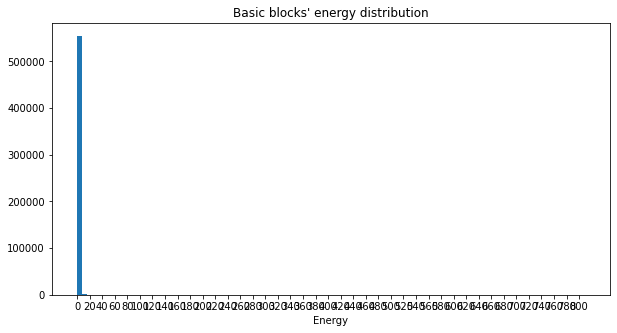

In [12]:
x_ticks = np.arange(data_df.energy.min(), data_df.energy.max(), 20)

plt.figure(figsize=(10, 5))
plt.hist(data_df.energy, bins=100)
plt.title("Basic blocks' energy distribution")
plt.xlabel("Energy")
plt.xticks(x_ticks)
plt.show()

In [13]:
outlier_bb = data_df.loc[data_df.energy.idxmax()]
outlier_bb.bb

['mov %r12d, %esi',
 'mov $0x2, %edi',
 'callq  0x250ee',
 'nop %edi, %edx',
 'pushq  %r12',
 'pushq  %rbp',
 'pushq  %rbx',
 'mov %esi, %ebx',
 'test %edi, %edi',
 'jnz 0x74']

We remove the outliers and data with 0 energy

In [14]:
perc = len(data_df[data_df.energy < 10]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 10: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 5]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 5: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 2]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 2: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 1]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 1: {round(perc, 2)}%")

perc = len(data_df[data_df.energy < 0.5]) * 100 / len(data_df)
print(f"Percentage of basic blocks with energy lower than 0.5: {round(perc, 2)}%")

perc = len(data_df[data_df.energy == 0.0]) * 100/ len(data_df)
print(f"Percentage of basic blocks with 0 energy: {round(perc, 2)}%")

Percentage of basic blocks with energy lower than 10: 99.84%
Percentage of basic blocks with energy lower than 5: 99.53%
Percentage of basic blocks with energy lower than 2: 97.41%
Percentage of basic blocks with energy lower than 1: 92.17%
Percentage of basic blocks with energy lower than 0.5: 81.36%
Percentage of basic blocks with 0 energy: 0.51%


In [15]:
data_df = data_df[data_df.energy > 0.0]
data_df = data_df[data_df.energy < 10.0]

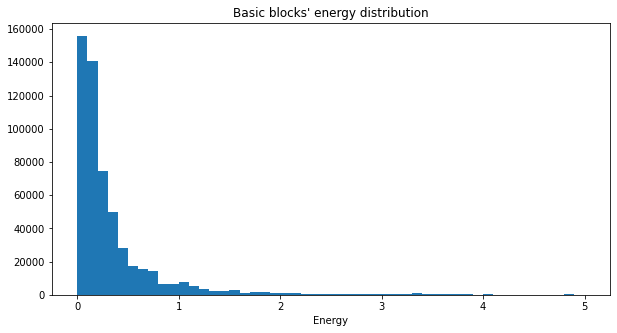

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(data_df.energy, range=(0, 5), bins=50)
plt.title("Basic blocks' energy distribution")
plt.xlabel("Energy")
plt.show()

In [18]:
median = np.median(data_df.energy.values)
std = np.std(data_df.energy.values)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.18174110027428655, Labels' std: 0.6428597933036999


In [19]:
grouped_df = data_df.groupby(data_df["bb"].map(tuple))["energy"].apply(list).reset_index()
grouped_df.head(5)

,bb,energy
0,"(add $0x1, %esi, cmp $0x270f, %esi, jnle 0xf)",[0.016677364772608463]
1,"(add $0x1, %esi, movl %esi, (%rax), cmpl %es...","[1.052697559160445, 1.5276753937910126, 0.5167..."
2,"(add $0x1, %r10, mov %rbx, %rdx, movsxb 0x1(%...","[0.27174238549467133, 0.27174238549467133, 0.2..."
3,"(add $0x1, %r15, movq 0x28(%r12), %rax, movzx...","[1.1483980499316333, 1.1483980499316333, 1.148..."
4,"(add $0x1, %r9d, cmpq $0x0, -0x500(%rbp), jz ...","[0.17353786933730966, 0.17353786933730966, 0.1..."


In [20]:
multiple_energies_df = grouped_df[grouped_df.energy.map(len) > 1]
perc = len(multiple_energies_df) * 100 / len(grouped_df)
print(f"Number of basic blocks that appear multiple times: {round(perc, 2)}%")

Number of basic blocks that appear multiple times: 65.1%


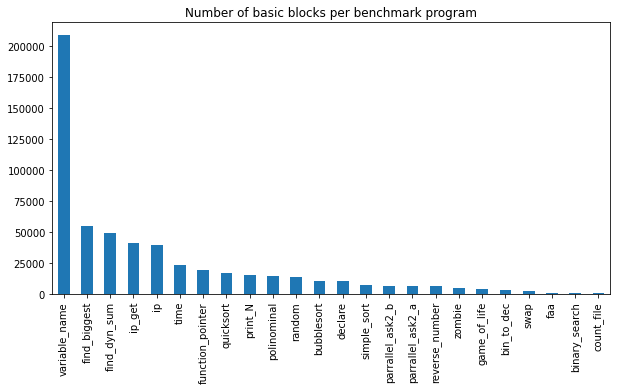

In [5]:
count_df = data_df.program_name.value_counts()

plt.figure(figsize=(10, 5))
count_df.plot.bar()
plt.title("Number of basic blocks per benchmark program")
plt.show()

# Energy distribution per program

Read file: 5500it [00:00, 1363799.70it/s]
Read file: 1007it [00:00, 672022.93it/s]


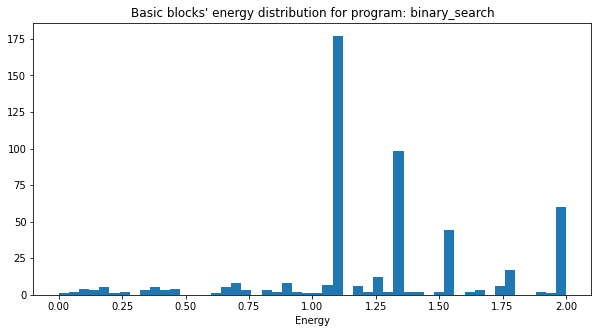

Read file: 23757it [00:00, 1584166.62it/s]
Read file: 3281it [00:00, 596640.43it/s]


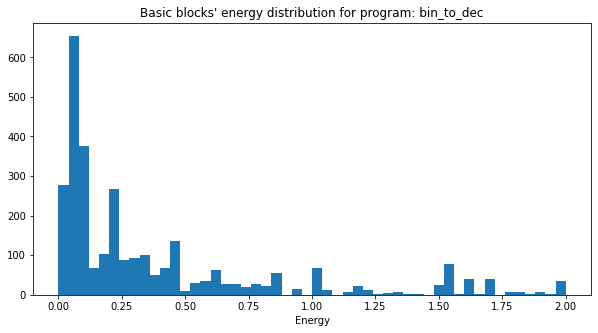

Read file: 65377it [00:00, 1405590.42it/s]
Read file: 10955it [00:00, 877032.32it/s]


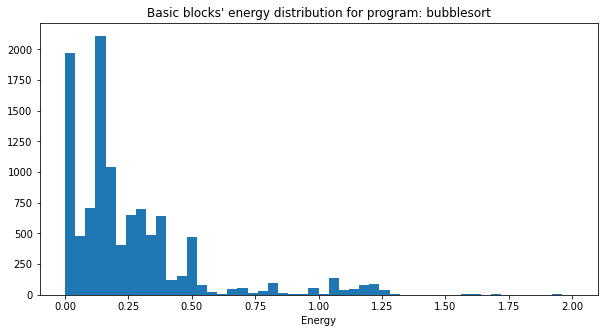

Read file: 6018it [00:00, 1718967.68it/s]
Read file: 988it [00:00, 658505.06it/s]


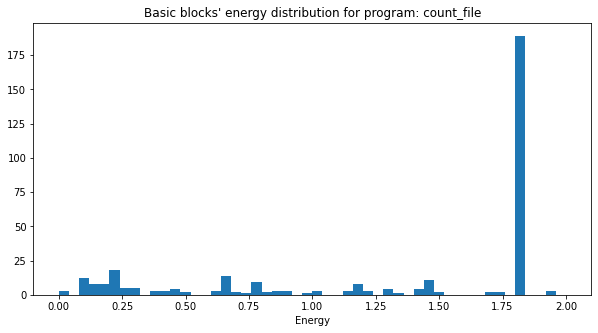

Read file: 58765it [00:00, 1632036.25it/s]
Read file: 10347it [00:00, 985500.00it/s]


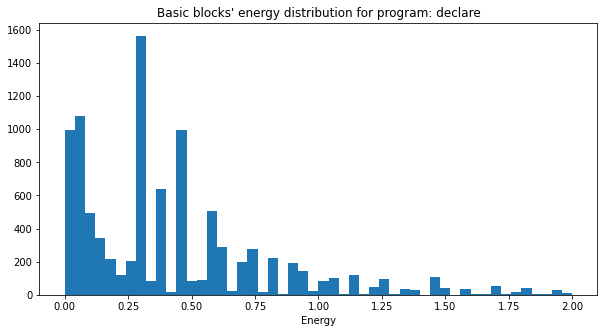

Read file: 7827it [00:00, 1563574.84it/s]
Read file: 1281it [00:00, 850277.48it/s]


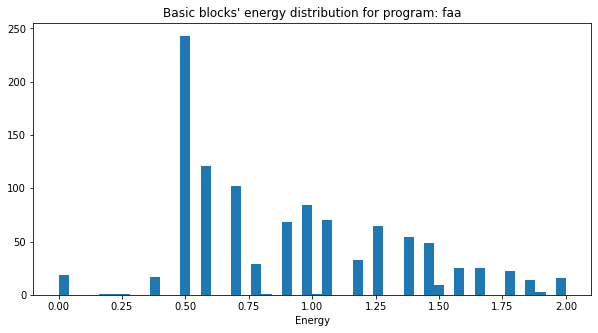

Read file: 307469it [00:00, 1666537.60it/s]
Read file: 55158it [00:00, 919289.92it/s]


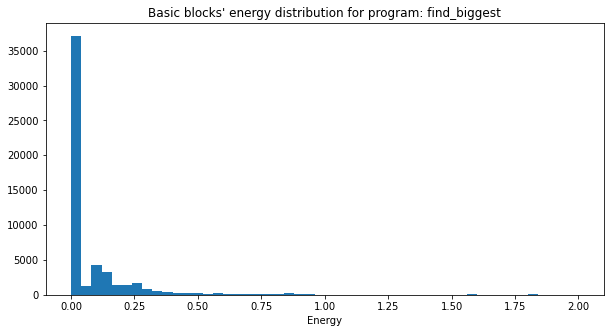

Read file: 300342it [00:00, 1725783.97it/s]
Read file: 49541it [00:00, 926013.47it/s]


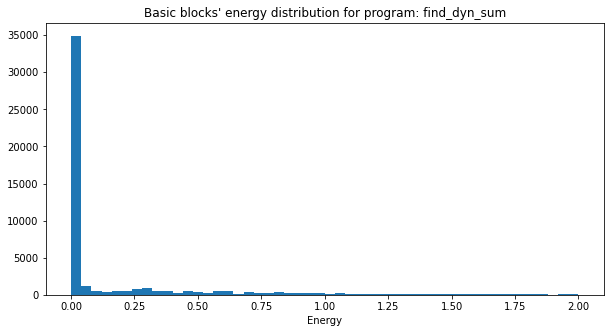

Read file: 117151it [00:00, 1511642.36it/s]
Read file: 19125it [00:00, 910811.32it/s]


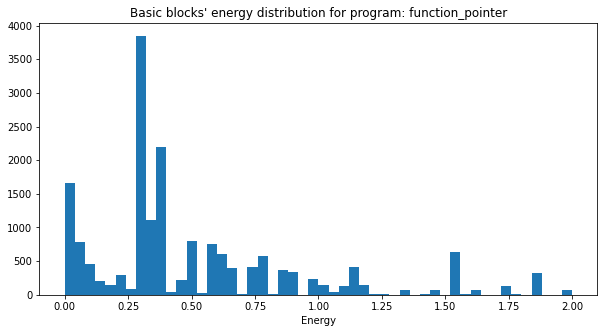

Read file: 32428it [00:00, 1581802.74it/s]
Read file: 3856it [00:00, 856860.20it/s]


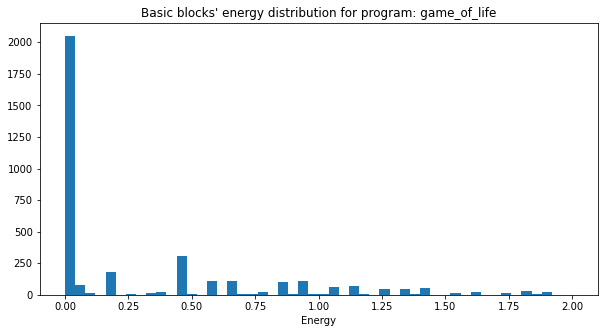

Read file: 252048it [00:00, 685846.11it/s] 
Read file: 41397it [00:00, 962705.30it/s]


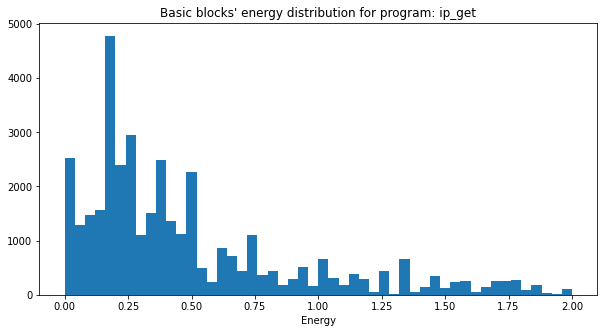

Read file: 226630it [00:00, 1723565.73it/s]
Read file: 39698it [00:00, 980308.98it/s]


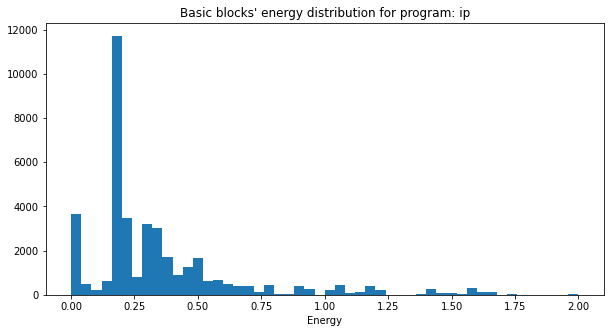

Read file: 45306it [00:00, 1564163.84it/s]
Read file: 6559it [00:00, 874402.13it/s]


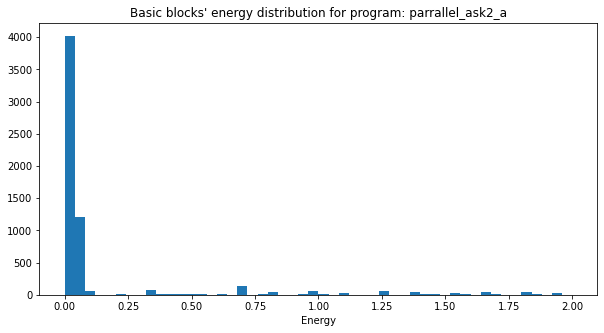

Read file: 45330it [00:00, 1618935.63it/s]
Read file: 6566it [00:00, 1009042.61it/s]


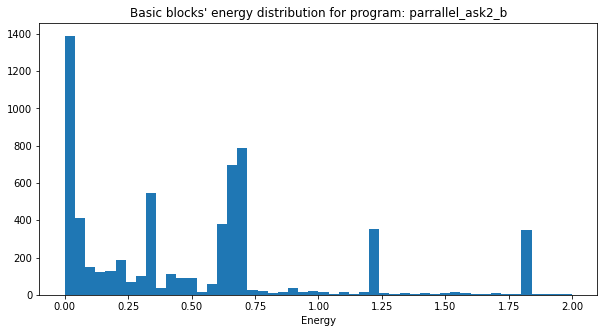

Read file: 87907it [00:00, 1569774.70it/s]
Read file: 14909it [00:00, 877100.47it/s]


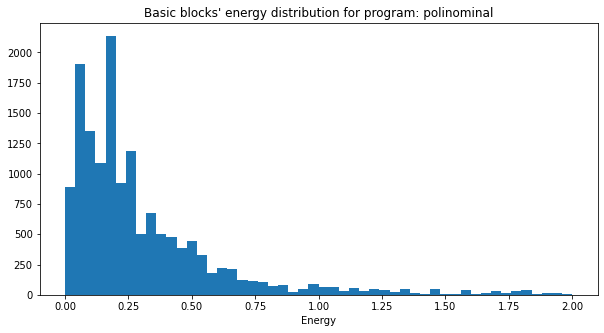

Read file: 96861it [00:00, 1574845.54it/s]
Read file: 15598it [00:00, 974495.48it/s]


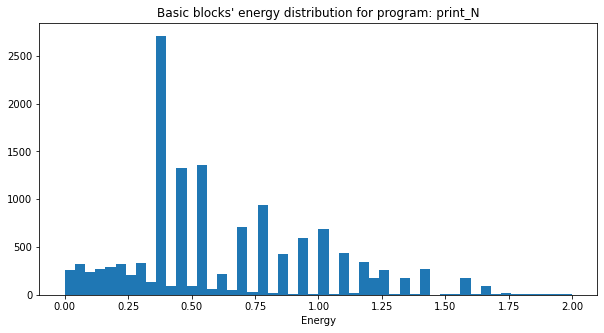

Read file: 112856it [00:00, 1654135.48it/s]
Read file: 17381it [00:00, 709445.47it/s]


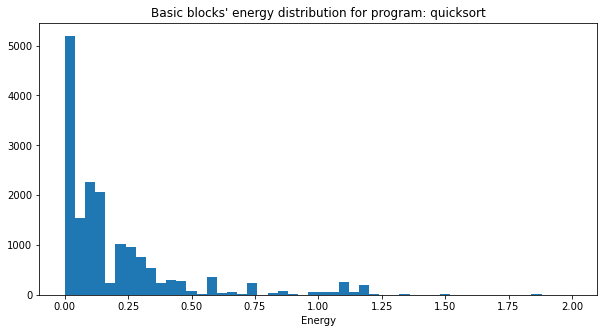

Read file: 87125it [00:00, 1628513.85it/s]
Read file: 13874it [00:00, 895134.12it/s]


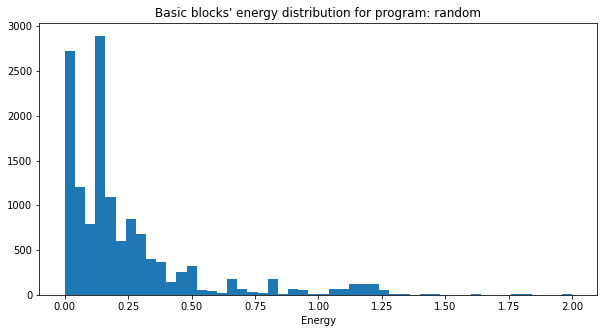

Read file: 37223it [00:00, 1583975.83it/s]
Read file: 6354it [00:00, 977752.78it/s]


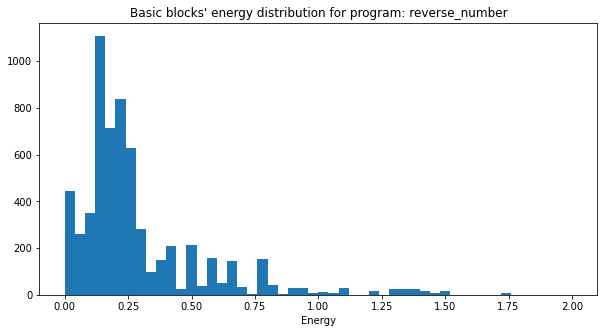

Read file: 43378it [00:00, 953356.80it/s]
Read file: 7697it [00:00, 513203.16it/s]


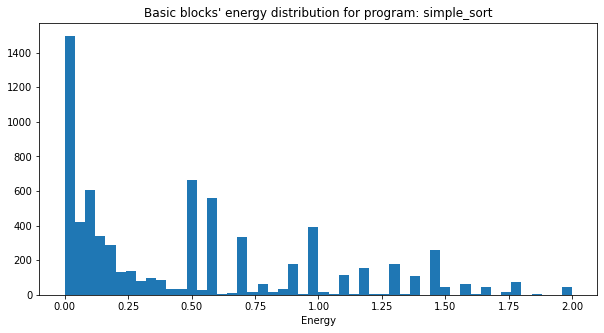

Read file: 15564it [00:00, 1482393.16it/s]
Read file: 2626it [00:00, 751107.63it/s]


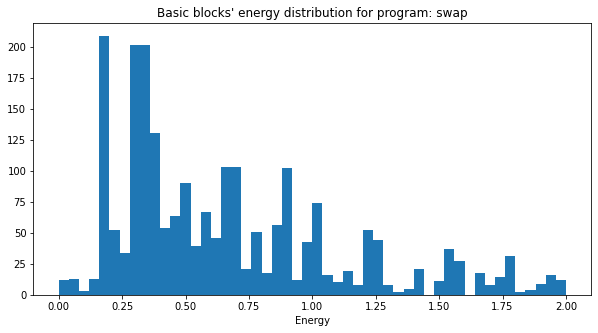

Read file: 142594it [00:00, 1575506.07it/s]
Read file: 23754it [00:00, 896644.02it/s]


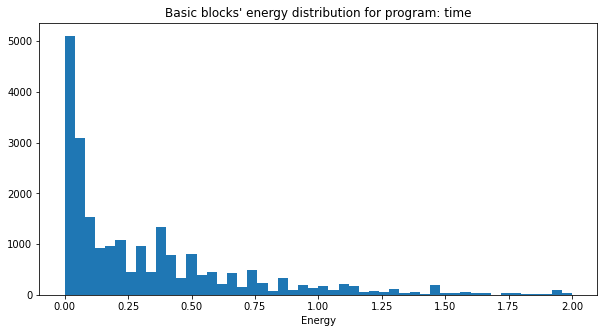

Read file: 1267388it [00:00, 1273764.87it/s]
Read file: 208473it [00:00, 951925.89it/s]


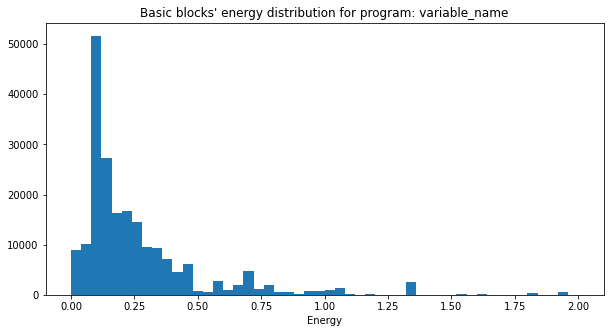

Read file: 36417it [00:00, 1517439.76it/s]
Read file: 5254it [00:00, 808455.25it/s]


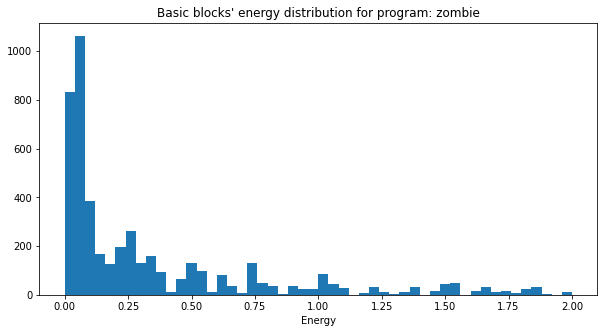

In [8]:
result_files = [f for f in os.listdir(f"{data_path}/") if f.endswith("results")]

for file in result_files:
    file_df = read_bb_data(f"{data_path}/{file}/breaker_code.txt", f"{data_path}/{file}/breaker_final_energy.txt")
    plt.figure(figsize=(10, 5))
    plt.hist(file_df.energy, range=(0, 2), bins=50)
    plt.title(f"Basic blocks' energy distribution for program: {file.rsplit('_results', 1)[0]}")
    plt.xlabel("Energy")
    #plt.savefig(f"/Users/thodo/Documents/sxoli/diplomatiki/dist_plots/{file}_energy_dist.png")
    plt.show()

# Labels Comparison Between Old and New runs

In [4]:
old_data_dir = "/Users/thodo/Documents/sxoli/diplomatiki/good_dataset"
comparison_programs = os.listdir(old_data_dir)

Read file: 5500it [00:00, 1222569.93it/s]
Read file: 1007it [00:00, 671809.15it/s]
Read file: 5500it [00:00, 999812.42it/s]
Read file: 1007it [00:00, 669784.99it/s]


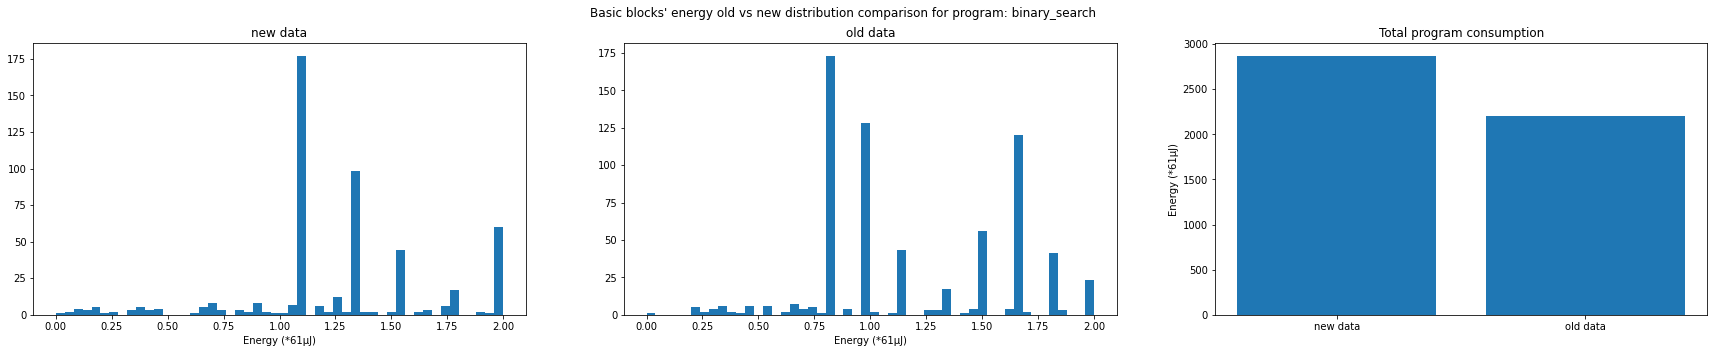

Read file: 32428it [00:00, 1118140.86it/s]
Read file: 3856it [00:00, 771771.15it/s]
Read file: 32428it [00:00, 1508304.76it/s]
Read file: 3856it [00:00, 771439.84it/s]


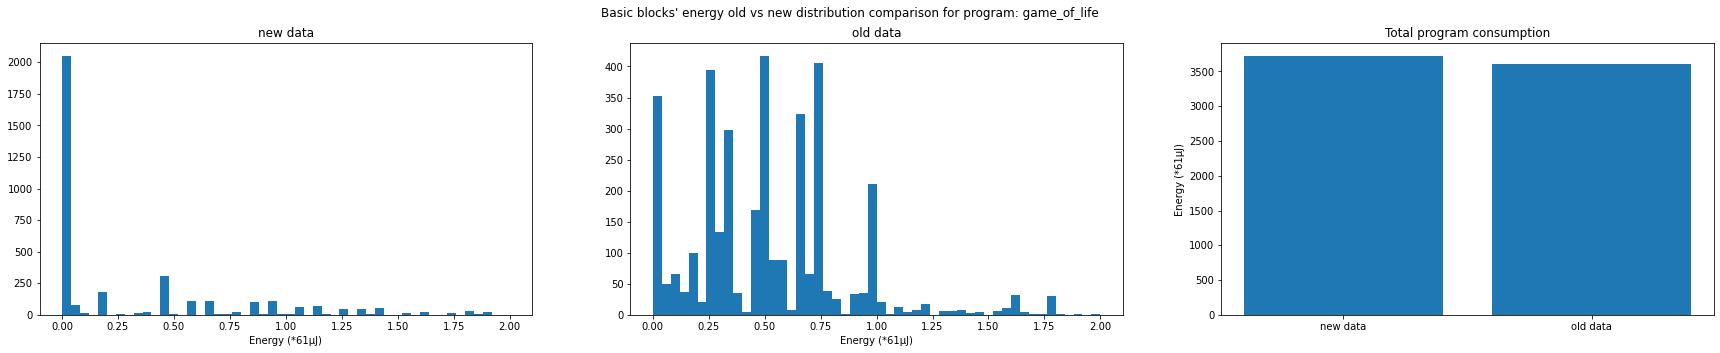

Read file: 96861it [00:00, 1587901.03it/s]
Read file: 15598it [00:00, 944992.18it/s]
Read file: 96857it [00:00, 1669932.02it/s]
Read file: 15598it [00:00, 974045.70it/s]


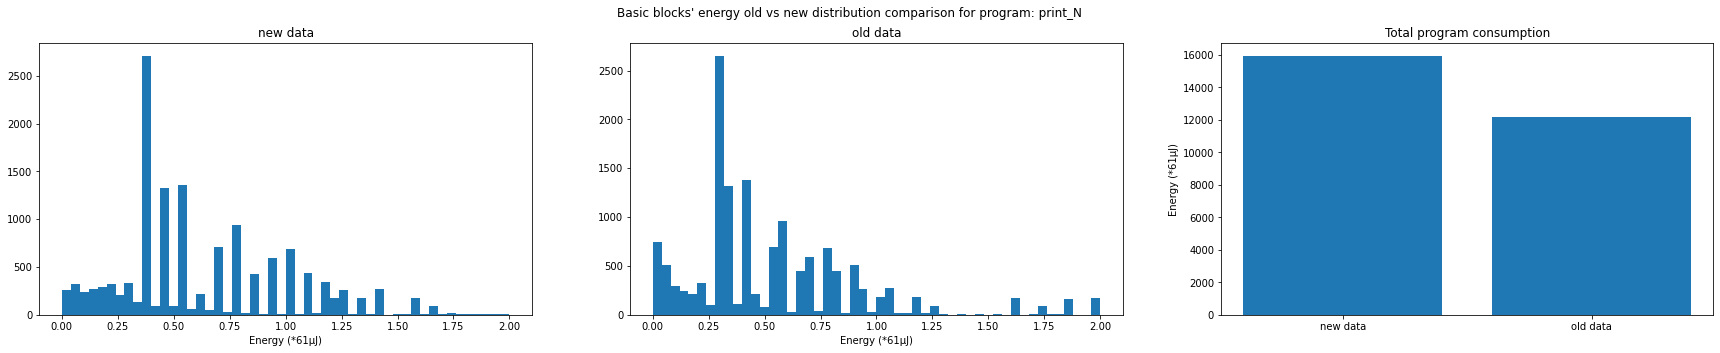

Read file: 15564it [00:00, 1557441.19it/s]
Read file: 2626it [00:00, 873730.15it/s]
Read file: 15556it [00:00, 1481833.10it/s]
Read file: 2626it [00:00, 873522.27it/s]


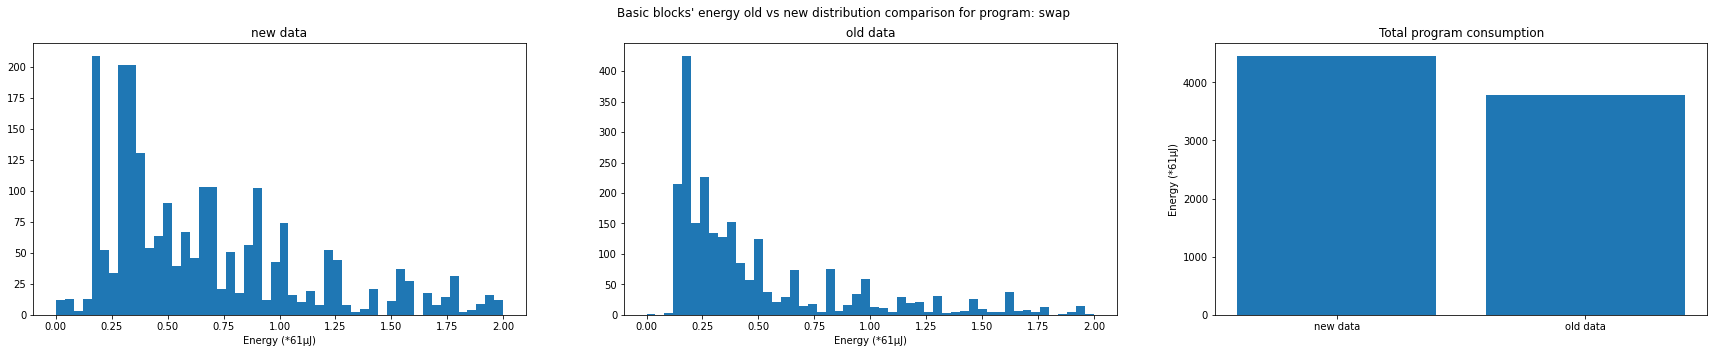

In [22]:
for file in comparison_programs:
    file_df = read_bb_data(f"{data_path}/{file}/breaker_code.txt", f"{data_path}/{file}/breaker_final_energy.txt")
    old_file_df = read_bb_data(f"{old_data_dir}/{file}/breaker_code.txt", f"{old_data_dir}/{file}/breaker_final_energy.txt")

    fig, axs = plt.subplots(1, 3, figsize=(30, 5))
    plt.suptitle(f"Basic blocks' energy old vs new distribution comparison for program: {file.rsplit('_results', 1)[0]}")
    axs[0].hist(file_df.energy, range=(0, 2), bins=50)
    axs[0].set_title('new data')
    axs[0].set_xlabel('Energy (*61μJ)')
    axs[1].hist(old_file_df.energy, range=(0, 2), bins=50)
    axs[1].set_title('old data')
    axs[1].set_xlabel('Energy (*61μJ)')
    axs[2].bar(["new data", "old data"], [sum(file_df.energy), sum(old_file_df.energy)])
    axs[2].set_title('Total program consumption')
    axs[2].set_ylabel('Energy (*61μJ)')
    plt.show()